In [1]:
import time
import numpy as np
import math
import random
import cv2 
from scipy.spatial import distance

#topological data analysis
from ripser import ripser
from persim import plot_diagrams

#plotting and visualization
from plotly.subplots import make_subplots
from matplotlib.patches import Circle

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm

from definitions import angle_from_side

#manifold learning and dim red
from sklearn.decomposition import PCA

#topological data analysis

from dreimac import CircularCoords, CircleMapUtils, GeometryExamples, PlotUtils, ComplexProjectiveCoords, ProjectiveMapUtils, GeometryUtils

#plotting and visualization
from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, Input, Output, no_update
import plotly.graph_objects as go
import pandas as pd
import base64

from PIL import Image

from numpy import linalg, matmul
from scipy import special


In [2]:
# upload the excel files using pandas

penta1 = np.loadtxt('data/sphere_clean.txt', delimiter=',')

print(penta1.shape)


(38303, 10)


In [3]:
penta1_img = []

for i in range(penta1.shape[0]) :
    penta1_img.append(cv2.imread('sphere - images/'+str(i+1)+'.png', cv2.IMREAD_GRAYSCALE))


In [4]:
penta1_img = np.array(penta1_img)

In [9]:
# penta1_img_col = []

# for i in range(penta1.shape[0]) :
#     penta1_img_col.append(cv2.imread('sphere - images/'+str(i+1)+'.png', cv2.IMREAD_COLOR))

# penta1_img_col = np.array(penta1_img_col)

Using ripser, we check for the persistent cohomology classes

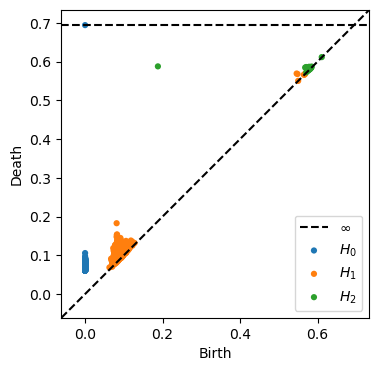

In [5]:
n_land = 900
res = ripser(penta1, n_perm = n_land, maxdim=2, coeff =13, thresh = 1.8)
dgms = res['dgms']
plt.figure(figsize = (4,4))
plot_diagrams(dgms)

In [28]:
pers1 = dgms[1][:,1] - dgms[1][:,0]
pers2 = dgms[2][:,1] - dgms[2][:,0]

pers1_sorted = np.sort(pers1)[::-1]
pers2_sorted = np.sort(pers2[pers2 < np.Inf])[::-1]
print('Sphere')
print('Persistence of top 10 1-d features:\n', np.around(pers1_sorted[0:10],decimals=2), '\n')
print('Persistence of top 10 2-d features:\n', np.around(pers2_sorted[0:10],decimals=2))


Sphere
Persistence of top 10 1-d features:
 [0.1  0.07 0.07 0.07 0.06 0.06 0.05 0.05 0.05 0.05] 

Persistence of top 10 2-d features:
 [0.4  0.02 0.02 0.01 0.01 0.01 0.01 0.01 0.   0.  ]


Using gedesic distance, we will view our sphere data:

In [3]:
P = penta1
dist_mat, pointcloud_permutation = GeometryUtils.landmark_geodesic_distance(P, 300, 20)

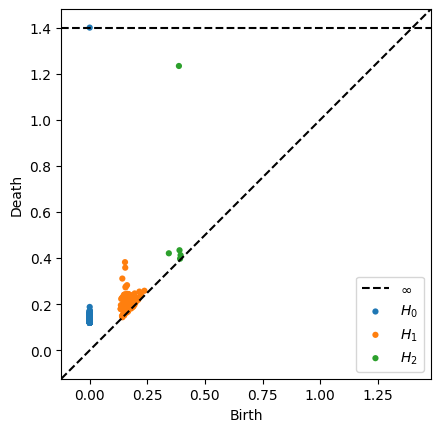

In [4]:
cpc = ComplexProjectiveCoords(dist_mat, n_landmarks=300, distance_matrix=True)
fig = plt.figure()
plot_diagrams(cpc.dgms_)
# fig.savefig('sphere-persistence')

Running the energy computation for the coloring of our images

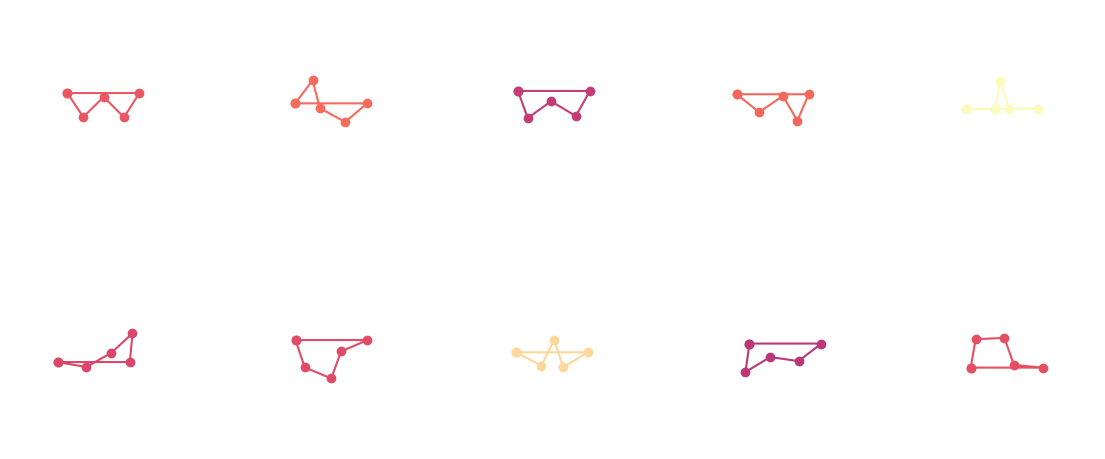

In [5]:
#Energy Computation

angle_data = np.zeros((penta1.shape[0],5)) # internal angles

for i in range(5):
    ii = (2*i -2)%10
    jj = (2*i - 1)%10
    u = penta1[:, [ii, jj]]
    
    ii = (2*i)%10
    jj = (2*i + 1)%10
    v = penta1[:, [ii , jj]]
    
    ii = (2*i + 2)%10
    jj = (2*i + 3)%10
    w = penta1[:, [ii, jj]]
    
    z = np.sum((u - v)*(w-v), axis = 1)
    
    angle_data[:,i]  = np.arccos( np.minimum(z,1) )
    
energy = np.sum((angle_data - (3/5)*np.pi)**2 , axis = 1)

# plot sample pentagons
fig = plt.figure(figsize=(14,6))
for i in range(10):
    ind = random.randint(0, penta1.shape[0])
    x = penta1[ind].reshape(5,2).T
    cent = np.mean(x,axis=1)
    plt.subplot(2,5,i+1)
    plt.plot(x[0,range(-1,5)], x[1,range(-1,5)] , '-o', c= cm.magma(energy[ind]/np.max(energy)))
    plt.axis('square')
    plt.axis('off')
    plt.xlim(cent[0]-1.3,cent[0]+1.3);
    plt.ylim(cent[1]-1.3,cent[1]+1.3);

fig.savefig('sphere-energy')

Below, we are using $\mathbb{CP}^1$ coordinates to plot our data

In [7]:

# n_lands = 800

# cpc1 = ComplexProjectiveCoords(penta1 , n_landmarks= n_lands)

# coho_classes = [0, 1, 3]

# complex_coords = []

# for i in coho_classes:
#     complex_coords.append(cpc1.get_coordinates(perc = 0.6, cocycle_idx=i, standard_range= False))

# # coords = cpc.get_coordinates(perc=0.9, proj_dim=1, cocycle_idx=0)
# # coords_R3 = ProjectiveMapUtils.hopf_map(coords)
# # coords_R2 = PrbojectiveMapUtils.stereographic_projection_hemispheres(coords_R3)

In [9]:
coords = cpc.get_coordinates(perc=0.9, proj_dim=1)
coords_R3 = ProjectiveMapUtils.hopf_map(coords)
coords_R2 = ProjectiveMapUtils.stereographic_projection_hemispheres(coords_R3)

KeyboardInterrupt: 

In [ ]:

fig = go.Figure(data=[go.Scatter3d(
    x=coords_R3[:,0], y=coords_R3[:,1], z=coords_R3[:,2], 
    mode ='markers', 
    marker=dict(size = 3, color =energy[pointcloud_permutation], colorscale='plasma' , opacity = 1)
)])

fig.update_layout(autosize=False, width=700, height=700)  
fig.show()

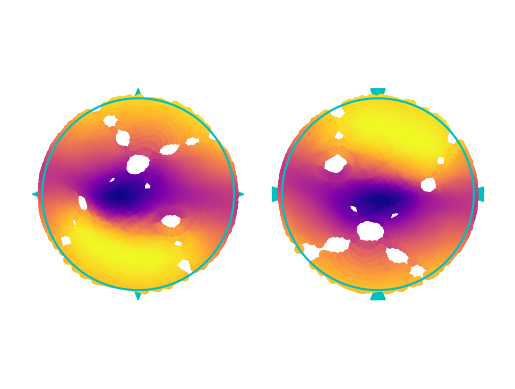

In [11]:
fig = plt.figure()
plt.axis("off")
_ = PlotUtils.plot_2sphere_boundary()
plt.scatter(coords_R2[:,0], coords_R2[:,1],c=energy[pointcloud_permutation], cmap='plasma')
_ = plt.axis("equal")
fig.savefig('hemispheres.png', facecolor='w', bbox_inches='tight')

hemisphere1 and hemisphere2 sort our data between the two images above. 

In [10]:
hemisphere1 = []
hemisphere2 = []

for i in coords_R2:
    if i[0] < 1.089:
        hemisphere1.append(i)
    else:
        hemisphere2.append(i)

hemisphere1 = np.array(hemisphere1)
hemisphere2 = np.array(hemisphere2)

In [ ]:
penta1_img_col[0].shape
imagebox = OffsetImage(penta1_img[0], zoom = 0.15)
ab = AnnotationBbox(imagebox, coords_R2[0])

In [13]:
subsample = GeometryUtils.get_greedy_perm_pc(coords_R2, 70)['perm']

In [14]:
reshape_img = np.array(np.reshape(penta1_img[pointcloud_permutation][subsample], (70, 389 * 389)))

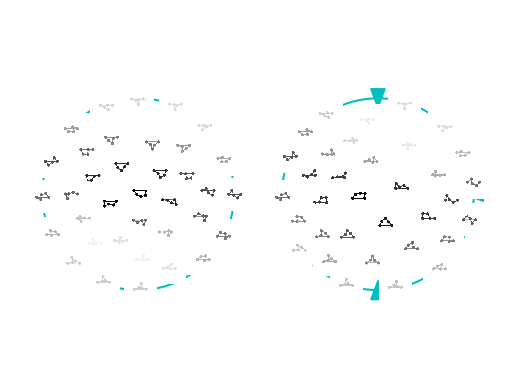

<Figure size 10000x6000 with 0 Axes>

In [15]:
fig = plt.figure()
plt.axis("off")
_ = PlotUtils.plot_2sphere_boundary()
PlotUtils.imscatter(coords_R2[subsample], reshape_img, 389, zoom=0.06)
_ = plt.axis("equal")
plt.figure(figsize=(100,60))
fig.savefig('patches.png', facecolor='w', bbox_inches='tight')

# Creating the local inverse via use of the Moore-Penrose pseudoinverse

sphericalcoords is our converted data in the form $r, \theta, \phi$ with the following diagram

In [7]:
sphericalcoords = []
for i in coords_R3:
    r = math.sqrt((i[0])**2 + (i[1])**2 + (i[2])**2)
    w = math.sqrt((-i[0])**2 + (i[1])**2)
    theta = math.acos((i[2])/r)
    phi = angle_from_side(i[0], i[1], w)
    sphericalcoords.append([r, theta, phi])

In [108]:
D = penta1.shape[0]
N = 100
mat = []

for row in range(N):
    for col in range(row+1):
        if col == 0 :
            mat.append((row, col))
        else:
            mat.append((row, col))
            mat.append((row, -1*col))

func = mat[:N]

In [109]:
A = []

for i in range(D):
    for ind in func:
        A.append(special.sph_harm(ind[1], ind[0], sphericalcoords[i][1], sphericalcoords[i][2]))

A = np.array(A)
A = A.reshape(D,N)

In [153]:
#Compute inverse
A_inv = linalg.pinv(A)
# u = matmul(A_inv, sphericalcoords)
u = matmul(A_inv, penta1)

In [156]:
error = (linalg.norm(penta1 - matmul(A, u)))
error = error/penta1.shape[0]
print(error)

0.0027817120361558526


In [86]:
start_time = time.time()
error_param = []

for param in range(100):
    mat = []
    for row in range(param):
        for col in range(row+1):
            if col == 0 :
                mat.append((row, col))
            else:
                mat.append((row, col))
                mat.append((row, -1*col))
    func = mat[:param]
    
    A = []
    for i in range(D):
        for ind in func:
            A.append(special.sph_harm(ind[1], ind[0], sphericalcoords[i][1], sphericalcoords[i][2]))
    A = np.array(A)
    A = A.reshape(D,param)
    A_inv = linalg.pinv(A)
    u = matmul(A_inv, sphericalcoords)
    error = (linalg.norm(sphericalcoords - matmul(A, u)))
    error = error/penta1.shape[0]
    error_param.append(error)

end_time = time.time()
print(end_time - start_time)

782.4553279876709


Text(0, 0.5, 'Average Error')

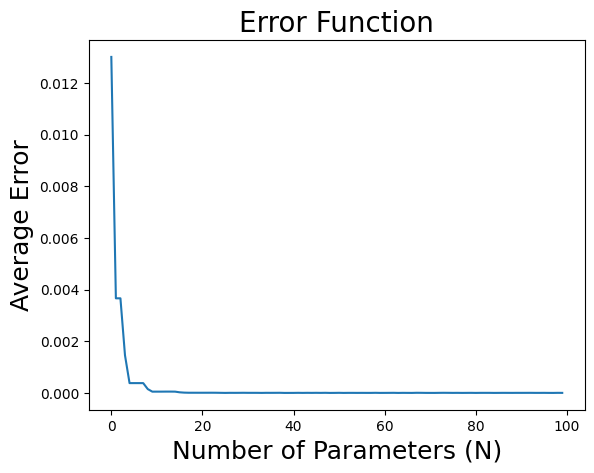

In [115]:
plt.plot(range(100), error_param)
plt.title("Error Function", fontsize=20)
plt.xlabel("Number of Parameters (N)", fontsize=18)
plt.ylabel("Average Error", fontsize=18)

Text(0, 0.5, 'Average Error')

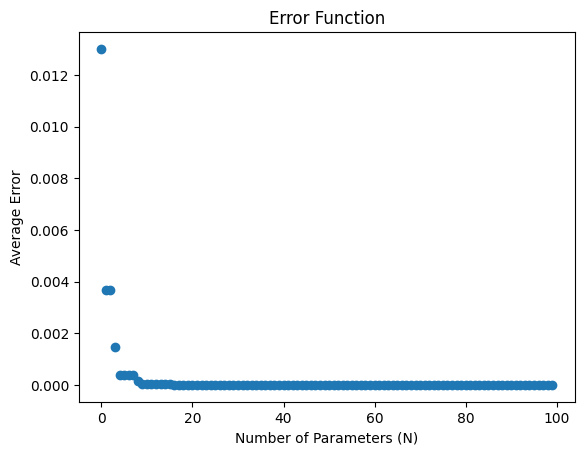

In [87]:
plt.scatter(range(100), error_param)
plt.title("Error Function")
plt.xlabel("Number of Parameters (N)")
plt.ylabel("Average Error")
# plt.savefig('error-fig')

In [9]:
# D = penta1.shape[0]
# N = 85
# A = []

# for i in range(D):
#     for j in range(N):
#         A.append(special.sph_harm(j+1, N, sphericalcoords[i][1], sphericalcoords[i][2]))
# A = np.array(A)
# A = A.reshape(D,N)

In [77]:
# start_time = time.time()
# error_param = []

# for param in range(86):
#     matrix = []
#     for i in range(D):
#         for j in range(param):
#             matrix.append(special.sph_harm(j+1, param, sphericalcoords[i][1], sphericalcoords[i][2]))
#     matrix = np.array(matrix)
#     matrix = matrix.reshape(D,param)
#     matrix_inv = linalg.pinv(matrix)
#     u = matmul(matrix_inv, sphericalcoords)
#     error_prime = (linalg.norm(sphericalcoords - matmul(matrix, u)))
#     error_prime = error_prime/penta1.shape[0]
#     error_param.append(error_prime)

# end_time = time.time()
# print(end_time - start_time)

# Filling in Data Gaps with Our Local Inverse

In [150]:
#Evenly sampling the sphere
data = GeometryExamples.sphere(10000)

fig = go.Figure(data=[go.Scatter3d(
    x=data[:,0], y=data[:,1], z=data[:,2], 
    mode ='markers', 
    marker=dict(size = 3, color = 'pink')
)])

fig.update_layout(autosize=False, width=700, height=700)  
fig.show()

In [147]:
sph_penta = matmul(A_inv, data)
sph_penta.shape

(100, 3)

# Now, we will try and recreate the PCA with hover data to detect missing pentagons.

1. First we will generate the images of each pentagon
2. Then, we will implement hover data


In [17]:
# saving sample pentagons as png files

# for i in range(10):
#     pentagon = plt.figure(figsize=(3,3), clear=True)
#     x = penta1[i].reshape(5,2).T
#     cent = np.mean(x,axis=1)
#     plt.plot(x[0,range(-1,5)], x[1,range(-1,5)] , '-o', c= cm.magma(energy[i]/np.max(energy)))
#     plt.axis('square')
#     plt.axis('off')
#     plt.xlim(cent[0]-1,cent[0]+1);
#     plt.ylim(cent[1]-1,cent[1]+1);
#     pentagon.savefig('sphere - images/'+str(i)+'.png', facecolor='w', bbox_inches='tight')
#     pentagon.clf
# #     plt.close()

# for i in range(penta1.shape[0]):
#     x = penta1[i].reshape(5,2).T
#     cent = np.mean(x,axis=1)
#     plt.plot(x[0,range(-1,5)], x[1,range(-1,5)] , '-o', c= cm.magma(energy[i]/np.max(energy)), linewidth = 7, markersize = 25)
#     plt.axis('square')
#     plt.axis('off')
#     plt.xlim(cent[0]-1.3,cent[0]+1.3);
#     plt.ylim(cent[1]-1.3,cent[1]+1.3);
#     plt.savefig('sphere - images/{}.png'.format(i+1), facecolor='w', bbox_inches='tight') 
#     plt.clf() 

<Figure size 640x480 with 0 Axes>

In [23]:
#PCA
pca = PCA(n_components=5)
data_pca = pca.fit(penta1).transform(penta1)

print('Explained Variance', pca.explained_variance_ratio_)

fig = go.Figure(data=[go.Scatter3d(
    x=data_pca[:,0], y=data_pca[:,1], z=data_pca[:,2], 
    mode ='markers', 
    marker=dict(size = 3, color =energy, colorscale='plasma' , opacity = 1)
)])

fig.update_layout(autosize=False, width=700, height=700)  

fig.show()

Explained Variance [0.49782957 0.18898558 0.12914586 0.10464718 0.05133602]


In [8]:
#Code block for displaying PCA data

fig = go.Figure(data=[go.Scatter3d(
    x=coords_R3[:,0], y=coords_R3[:,1], z=coords_R3[:,2], 
    mode ='markers', 
    marker=dict(size = 3, color =energy[pointcloud_permutation], colorscale='plasma' , opacity = 1)
)])

fig.update_traces(hoverinfo="none", hovertemplate=None)
fig.update_layout(
    scene = dict(
        xaxis = dict(range=[-1,1],),
        yaxis = dict(range=[-1,1],),
        zaxis = dict(range=[-1,1],),
    ), width=700, height=700
)

app = JupyterDash(__name__)

server = app.server

app.layout = html.Div([
    dcc.Graph(id="graph-basic-2", figure=fig, clear_on_unhover=True),
    dcc.Tooltip(id="graph-tooltip"),
])


@app.callback(
    Output("graph-tooltip", "show"),
    Output("graph-tooltip", "bbox"),
    Output("graph-tooltip", "children"),
    Input("graph-basic-2", "hoverData"),
)

def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    # demo only shows the first point, but other points may also be available
    pt = hoverData["points"][0]
    bbox = pt["bbox"]
    num = pt["pointNumber"]

    img_fname = 'sphere - images/'+str(pointcloud_permutation[num])+'.png'
    encoded_img = base64.b64encode(open(img_fname, 'rb').read())

    children = [
        html.Div([
            html.Img(src='data:image/png;base64,{}'.format(encoded_img.decode()), style={'width': '100%'}),
        ], style={'width': '80px', 'white-space': 'normal'})
    ]

    return True, bbox, children

app.run_server(mode="inline")


In [ ]:

# sample1 = penta1[2000]
# x_val = []
# y_val = []

# for i in range(10):
#     if i%2 == 0:
#         x_val.append(sample1[i])
#     else: 
#         y_val.append(sample1[i])

# # print(sample1)
# # print(x_val)
# # print(y_val)

# plt.plot(x_val, y_val)
# plt.scatter(x_val, y_val)


In [ ]:
# img = cv2.imread('sphere - images/1200.png', cv2.IMREAD_GRAYSCALE)

# # print("Shape of the loaded image is", img.shape)
# # print(img)

# # image = Image.fromarray(img, 'RGB')
# # image.show()